## Statistical Analyses

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

#### Data Loading and Preprocessing

In this step, we load the processed hop dataset from a Parquet file.  
Parquet is a compressed, efficient columnar storage format, ideal for structured tabular data with complex types (like lists).  

After loading, we perform **mean imputation** on all numeric columns to ensure that missing values (NaNs) do not break downstream analyses or model training.

Mean imputation replaces each missing value with the average of its column - common and simple strategy when dealing with continuous data.

In [132]:
parquet_path = 'processed_hop_data.parquet'

try:
    hop_df = pd.read_parquet(parquet_path)

    # Confirm successful load
    print(f'Data loaded from Parquet: {hop_df.shape[0]} rows × {hop_df.shape[1]} columns.')
    print(hop_df.head())

    # Identify numeric columns for imputation
    numeric_cols = hop_df.select_dtypes(include='number').columns

    # Mean imputation of missing numeric values
    imputer = SimpleImputer(strategy='mean')
    hop_df[numeric_cols] = pd.DataFrame(
        imputer.fit_transform(hop_df[numeric_cols]),
        columns=numeric_cols,
        index=hop_df.index
    )

    print('\nMissing numeric values have been mean-imputed.')

except FileNotFoundError:
    print(f'Error: {parquet_path} not found. Did you run the preprocessing step and export it?')


Data loaded from Parquet: 100 rows × 14 columns.
      name purpose  alpha_acid_avg  beta_acid_avg  alpha_beta_ratio    hsi  \
0     None    None             NaN            NaN               NaN   None   
1    Astra    Dual             8.5            5.0               1.5   None   
2  Eclipse    Dual            17.4            7.5               1.5   None   
3     Ella    Dual            16.3            5.9               2.0   None   
4   Enigma   Aroma            16.5            5.8               2.0  0.295   

  cohumulone_%_of_alpha  total_oils_avg  myrcene  humulene  caryophyllene  \
0                  None             NaN      NaN       NaN            NaN   
1               27% avg             2.0      NaN       7.0            2.5   
2               35% avg             2.3     42.0       1.0            9.0   
3             36.5% avg             2.9     42.0      18.5           11.5   
4               40% avg             2.4     26.5      15.5            7.0   

   farnesene       

#### Parameter Definitions

Here, we define the number of unique tags and beer styles to retain.

Limiting to the **top K most frequent** categories helps reduce:
- High dimensionality
- Model overfitting
- Noise from rarely used tags or styles

Tags and styles outside the top K will be grouped into a generic `'other'` category.


In [133]:
# === Parameters ===
TOP_K_TAGS = 10           # Limit to top 20 most frequent tags.
TOP_K_STYLES = 10         # Limit to top 20 most frequent beer styles.

#### Cleaning and Simplifying Categorical Variables

The `limit_top_k_categories()` function:
- Flattens all lists of tags/styles
- Identifies the top `K` most frequent
- Replaces all others with `'other'`

This is crucial to prevent rare tags from producing one-hot columns that will contain mostly zeros and not generalize well.

This step also prints the top retained tags/styles with their frequencies to help validate the result.

In [ ]:
def limit_top_k_categories(series, k, label='(unnamed)'):
    '''
    Replace infrequent values in a list-based column with 'other'.
    Helps control the number of binary features created during encoding.
    Also prints the top-K values that are retained.

    Parameters:
        series : pd.Series of list[str]
        k : int, number of top categories to keep
        label : str, name of the column (optional, for logging clarity)

    Returns:
        Series with infrequent values replaced by 'other'
    '''
    # Flatten all list entries in the column.
    all_items = [item for row in series for item in row]

    # Count occurrences and select top-K.
    counter = Counter(all_items)
    top_k = set(tag for tag, _ in counter.most_common(k))

    # Print the retained values for transparency.
    print(f'\nTop {k} categories retained in "{label}":')
    for tag in sorted(top_k):
        print(f'  {tag} ({counter[tag]})')

    # Replace values not in top-K with 'other'.
    return series.apply(lambda lst: [x if x in top_k else 'other' for x in lst])

#### Multi-hot Encoding

I use `multi_hot_encode()` to convert each list of tags or styles into a **binary vector**:
- Each column becomes a unique tag or style
- A value of `1` means the hop has that tag/style
- A value of `0` means it does not

 **Multi-hot encoding** is necessary because most machine learning models do not understand raw lists or strings — they require fixed-size numeric input vectors.

In [135]:
def multi_hot_encode(series):
    '''
    Multi-hot encode a column where each row is a list of strings.
    Returns a DataFrame with one binary column per unique value.
    '''
    mlb = MultiLabelBinarizer()
    return pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)

In [ ]:
%%capture

def run_pca_grid(features_dict, label_dict):
    '''
    Run PCA across multiple feature sets and label columns with smarter filtering.

    Rules:
    - Do not run 'tags' feature set on tag labels like 'tag:citrus'
    - Do not run 'styles' feature set on style labels like 'style:IPA'
    - When running on 'tag:xyz', use all features except tag features
    - When running on 'style:xyz', use all features except style features
    '''
    for feat_name, feat_df in features_dict.items():
        for label_name, label_data in label_dict.items():
            skip = False

            # Skip if we're running 'tags' on tag-specific label
            if feat_name == 'tags' and label_name.startswith('tag:'):
                skip = True

            # Skip if we're running 'styles' on style-specific label
            if feat_name == 'styles' and label_name.startswith('style:'):
                skip = True

            # Build custom feature subset for tag/style labels
            if feat_name == 'all_features':
                if label_name.startswith('tag:'):
                    feat_df = features_dict['all_features'].drop(columns=tags_encoded.columns, errors='ignore')
                elif label_name.startswith('style:'):
                    feat_df = features_dict['all_features'].drop(columns=styles_encoded.columns, errors='ignore')

            if skip:
                print(f'⏭️  Skipping PCA: {feat_name} with label {label_name}')
                continue

            print(f'\n🔍 Running PCA on {feat_name} colored by {label_name}...')
            try:
                run_pca_analysis(
                    features_df=feat_df,
                    label_series=label_data,
                    title=f'PCA: {feat_name} by {label_name}'
                )
            except Exception as e:
                print(f'❌ Skipped {feat_name} by {label_name} — Reason: {e}')

In [139]:
def run_svd_analysis(features_df, label_series=None, title='Truncated SVD Projection', n_components=2):
    '''
    Perform Truncated SVD (aka LSA) on sparse/binary features and visualize a 2D projection.

    Parameters:
    ----------
    features_df : pd.DataFrame
        DataFrame of binary or sparse features (e.g., multi-hot encoded tags or styles)

    label_series : pd.Series, optional
        Series of labels to color the scatter plot. Can be categorical (e.g., purpose)
        or numeric (e.g., a chemical measurement).

    title : str
        Title for the plot

    n_components : int
        Number of SVD dimensions to reduce to (default 2 for 2D plotting)

    Returns:
    -------
    svd : fitted TruncatedSVD model
    '''
    # Step 1: Initialize Truncated SVD
    svd = TruncatedSVD(n_components=n_components)

    # Step 2: Fit and transform the features into low-dimensional space
    projected = svd.fit_transform(features_df)

    # Step 3: Create a 2D scatter plot of the projection
    plt.figure(figsize=(8, 6))

    if label_series is not None:
        # Use seaborn to color points by label if provided
        sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=label_series, palette='tab10')
    else:
        # Otherwise just scatter with default color
        plt.scatter(projected[:, 0], projected[:, 1], alpha=0.7)

    # Step 4: Annotate plot
    plt.title(title)
    plt.xlabel(f'SVD Component 1')
    plt.ylabel(f'SVD Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return svd

In [ ]:
# === Preprocessing ===

# Step 1: Filter high-cardinality features
hop_df['tags'] = limit_top_k_categories(hop_df['tags'], TOP_K_TAGS)
hop_df['beer_styles'] = limit_top_k_categories(hop_df['beer_styles'], TOP_K_STYLES)

# Step 2: Multi-hot encode filtered tags and styles
tags_encoded = multi_hot_encode(hop_df['tags'])
styles_encoded = multi_hot_encode(hop_df['beer_styles'])

# Step 4: Combine all feature sets into final model-ready DataFrame
df_model = pd.concat([
    hop_df[numeric_cols],
    tags_encoded,
    styles_encoded
], axis=1)

# Output basic info
print('Final shape of modeling DataFrame:', df_model.shape)
print('Feature columns included:')
print(df_model.columns.tolist())

# Step 5: Bin alpha_beta_ratio into 3 groups for better color labeling
hop_df['alpha_beta_group'] = pd.qcut(hop_df['alpha_beta_ratio'], q=3, labels=['Low', 'Medium', 'High'])

# === Define PCA feature sets and labels for automated exploration ===

# Feature blocks to analyze
features_dict = {
    'chemistry': hop_df[numeric_cols],
    'tags': tags_encoded,
    'styles': styles_encoded,
    'all_features': df_model
}

# Label columns to color plots by
label_dict = {
    'purpose': hop_df['purpose'],
    'alpha_beta_group': hop_df['alpha_beta_group']
}

# Add specific tag/style binary columns (if they exist)
for tag in ['citrus', 'floral', 'grassy']:
    if tag in tags_encoded.columns:
        label_dict[f'tag:{tag}'] = tags_encoded[tag]

for style in ['IPA', 'Lager']:
    if style in styles_encoded.columns:
        label_dict[f'style:{style}'] = styles_encoded[style]


Top 10 categories retained in "(unnamed)":
  citrus (36)
  earthy (13)
  floral (27)
  fruity (15)
  herbal (17)
  noble (13)
  passion_fruit (18)
  pine (15)
  spicy (28)
  tropical_fruit (14)

Top 10 categories retained in "(unnamed)":
  Ale (9)
  Belgian Ale (17)
  IPA (33)
  Kolsch (6)
  Lager (37)
  Pale Ale (29)
  Pilsner (27)
  Saison (14)
  Stout (7)
  Wheat (9)
Final shape of modeling DataFrame: (100, 30)
Feature columns included:
['alpha_acid_avg', 'beta_acid_avg', 'alpha_beta_ratio', 'total_oils_avg', 'myrcene', 'humulene', 'caryophyllene', 'farnesene', 'citrus', 'earthy', 'floral', 'fruity', 'herbal', 'noble', 'other', 'passion_fruit', 'pine', 'spicy', 'tropical_fruit', 'Ale', 'Belgian Ale', 'IPA', 'Kolsch', 'Lager', 'Pale Ale', 'Pilsner', 'Saison', 'Stout', 'Wheat', 'other']


#### PCA

PCA reduces the dimensionality of a dataset while preserving as much variance (information) as possible.

I project the high-dimensional feature matrix (chemistry + tags + styles) and color the points by `purpose`.

In [ ]:
def run_pca_analysis(features_df, label_series=None, title='PCA Projection'):
    '''
    Perform PCA on a set of features and visualize the 2D projection.

    Parameters:
    ----------
    features_df : pd.DataFrame
        A DataFrame of numeric features (e.g., multi-hot encoded tags or styles)
        where each row represents a sample and each column is a binary or continuous feature.

    label_series : pd.Series, optional
        A series of categorical labels used to color the scatter plot (e.g., purpose, target).
        If None, points will be uncolored.

    title : str
        A title to display above the PCA plot.

    Returns:
    -------
    pca : PCA object
        The fitted PCA model, which includes explained variance and components.
    '''

    # Initialize PCA to reduce features to 2 components
    pca = PCA(n_components=2)

    # Fit PCA to the features.
    # Each row will now be a 2D coordinate representing the sample in principal component space.
    projected = pca.fit_transform(features_df)

    # Create a scatter plot of the PCA results.
    plt.figure(figsize=(8, 6))

    if label_series is not None:
        # Color the points by the provided label.
        sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=label_series, palette='tab10')
    else:
        # Plain scatter without labels.
        plt.scatter(projected[:, 0], projected[:, 1], alpha=0.7)

    # Add plot labels and formatting.
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the fitted PCA model.
    return pca

#### PCA of All Features Colored by Purpose

This plot shows a PCA projection of the full hop feature dataset into two dimensions.

- The first component (PC1) explains **62% of the total variance**, while the second (PC2) explains **20.4%**, capturing a total of over **82%** of the dataset’s variability in just two dimensions.
- Each point represents one hop variety, and is colored by its **brewing purpose**: `Aroma`, `Bittering`, or `Dual-use`.
- **Separation between categories** is modest. There is no clear linear separation between Aroma, Bittering, and Dual hops, indicating that the chosen features don't fully distinguish usage types.
- **PC1 (horizontal axis)** captures the majority of feature variation, likely driven by key numeric chemical traits (like alpha/beta ratio or oil content).
- **PC2 (vertical axis)** adds some extra variation but does not show strong clustering by purpose either.
- Some `Bittering` and `Dual-use` hops appear closer together, which is expected since these classes can share overlapping characteristics.
- The central clustering of `Aroma` hops suggests less chemical variability in that group.

Further analysis could explore:
- PCA loadings to understand which features contribute most to PC1/PC2.
- Other dimensionality reduction techniques like t-SNE or UMAP.
- Feature importance from a purpose-prediction classifier.

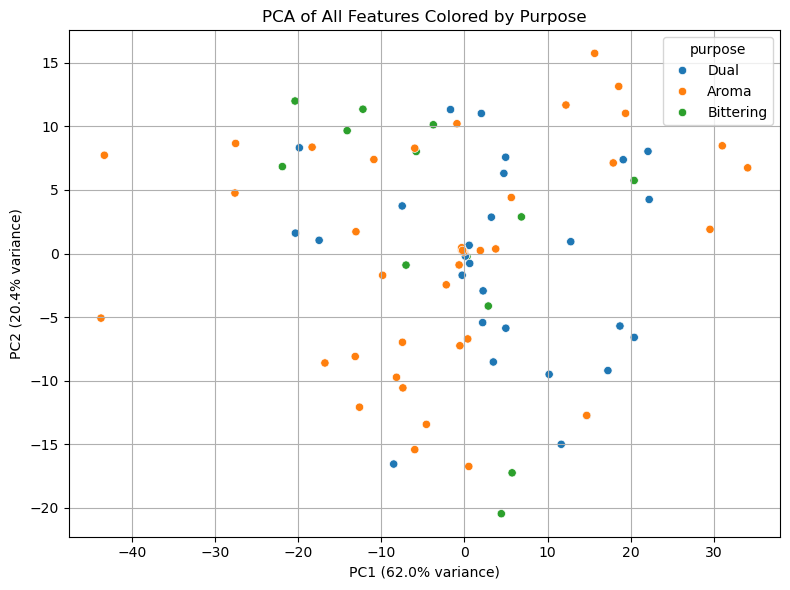

PCA(n_components=2)

In [141]:
run_pca_analysis(
    features_df=df_model,
    label_series=hop_df['purpose'],
    title='PCA of All Features Colored by Purpose'
)

In [138]:
def run_mds_analysis(features_df, label_series=None, title='MDS Projection', metric='euclidean'):
    '''
    Perform MDS to project feature distances into 2D space for visualization.
    '''
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

    # Compute distance matrix first
    distance_matrix = pairwise_distances(features_df, metric=metric)

    # Fit MDS on distance matrix
    projected = mds.fit_transform(distance_matrix)

    # Plot result
    plt.figure(figsize=(8, 6))
    if label_series is not None:
        sns.scatterplot(x=projected[:, 0], y=projected[:, 1], hue=label_series, palette='tab10')
    else:
        plt.scatter(projected[:, 0], projected[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel('MDS1')
    plt.ylabel('MDS2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mds

#### MDS of All Features Colored by Purpose

This plot displays the result of **Multidimensional Scaling (MDS)** applied to the full hop feature set, using **Euclidean distance** to compute dissimilarities between hops.

- MDS constructs a spatial layout where the **distances between points in 2D** reflect the original pairwise distances in high-dimensional feature space.
- Unlike PCA (which maximizes variance explained), MDS is **distance-preserving** — it focuses on representing **how similar or dissimilar** each hop is from the others, based on their feature values.
- Each point in the plot is a hop, colored by its brewing **purpose**: `Aroma`, `Bittering`, or `Dual-use`.

- Hops with similar chemical and categorical profiles are placed **closer together** in the 2D space.
- There is no strong linear separation among `Aroma`, `Bittering`, and `Dual` hops — they **overlap significantly**, suggesting a continuum rather than discrete clusters.
- That said, there are **pockets of localized grouping**, especially for `Dual` hops, which appear slightly more centralized, and some `Aroma` hops pushed to the extremes, indicating more phenotypic variation.
- This spread likely reflects **variation in multi-hot tags and chemical ratios** that do not align cleanly with purpose labels.

MDS reveals that hop `purpose` is not sharply defined by simple pairwise distances in the full feature space.  

Further exploration could involve:
- Using other distance metrics (e.g., cosine, Jaccard).
- Running MDS on subsets (just chemistry, or just tags).
- Comparing MDS to t-SNE or UMAP for non-linear embeddings.

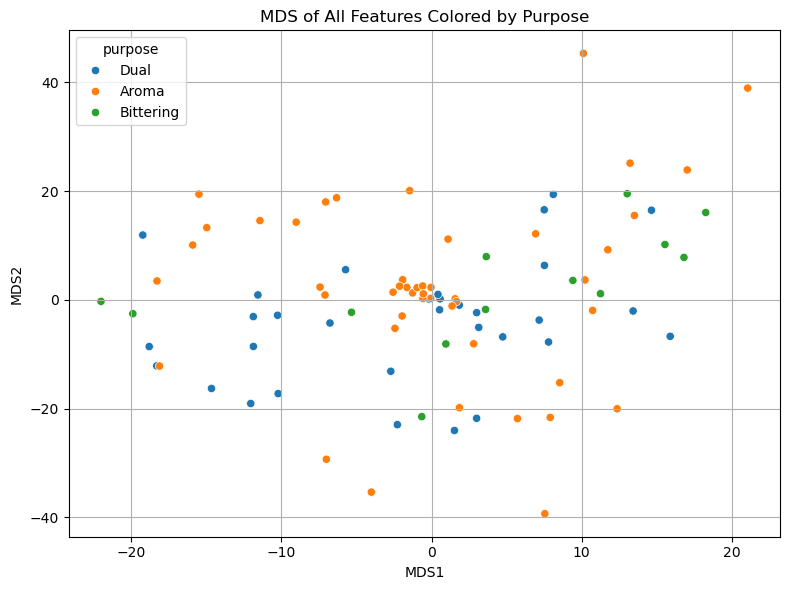

MDS(dissimilarity='precomputed', random_state=42)

In [142]:
# Run MDS using all features (e.g., df_model) and color by hop purpose
run_mds_analysis(
    features_df=df_model,
    label_series=hop_df['purpose'],
    title='MDS of All Features Colored by Purpose',
    metric='euclidean'  # Best for mixed numeric + binary features
)


Correlation between chemical features and tags:
                  citrus  earthy  floral  fruity  herbal  noble  other  \
alpha_acid_avg      0.03   -0.05   -0.30    0.01   -0.14  -0.24   0.19   
beta_acid_avg      -0.12   -0.05   -0.23   -0.03   -0.16  -0.17   0.03   
alpha_beta_ratio    0.06   -0.02   -0.20    0.00   -0.04  -0.18   0.12   
total_oils_avg      0.16   -0.13   -0.28   -0.02   -0.11  -0.18   0.17   
myrcene             0.29   -0.21   -0.05   -0.04   -0.10  -0.25   0.12   
humulene           -0.05    0.14    0.16    0.12    0.08   0.21  -0.05   
caryophyllene      -0.11    0.05    0.04    0.04   -0.01   0.23  -0.10   
farnesene          -0.13    0.16    0.32   -0.20    0.14   0.13  -0.03   

                  passion_fruit  pine  spicy  tropical_fruit  
alpha_acid_avg             0.20  0.23  -0.13            0.36  
beta_acid_avg              0.23  0.14  -0.15            0.16  
alpha_beta_ratio           0.04  0.05  -0.08            0.17  
total_oils_avg             0.25 

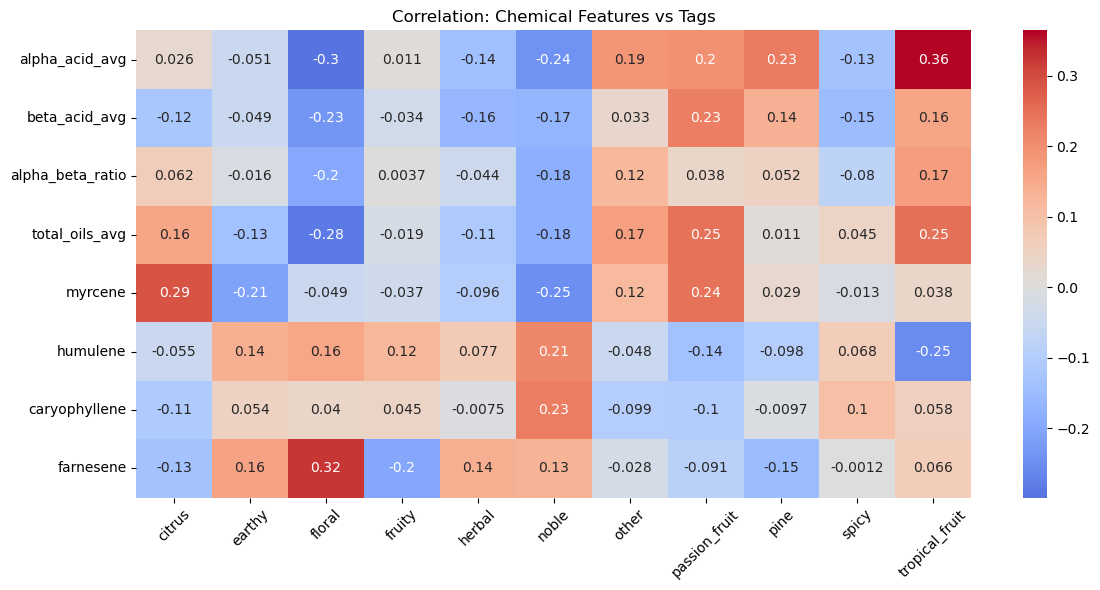

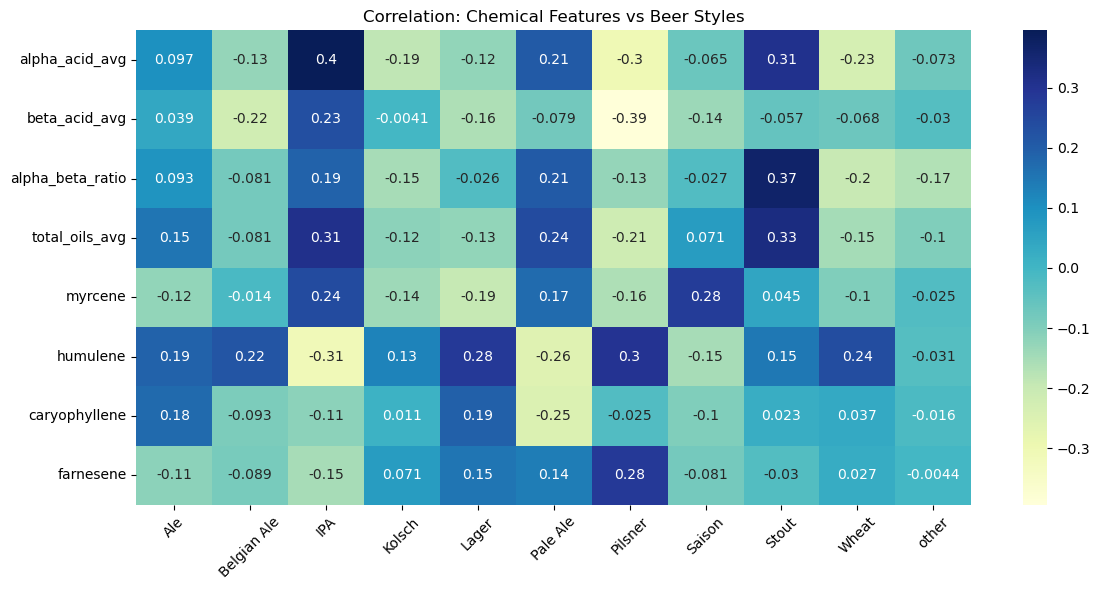

In [ ]:
# Combine numeric and tag features
chem_vs_tags = pd.concat([hop_df[numeric_cols], tags_encoded], axis=1)

# Compute correlation matrix
correlation_matrix = chem_vs_tags.corr()

# Extract correlations between numeric columns and tag columns
tag_corrs = correlation_matrix.loc[numeric_cols, tags_encoded.columns]

print('\nCorrelation between chemical features and tags:')
print(tag_corrs.round(2))

plt.figure(figsize=(12, 6))
sns.heatmap(tag_corrs, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation: Chemical Features vs Tags')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


chem_vs_styles = pd.concat([hop_df[numeric_cols], styles_encoded], axis=1)
style_corrs = chem_vs_styles.corr().loc[numeric_cols, styles_encoded.columns]

plt.figure(figsize=(12, 6))
sns.heatmap(style_corrs, annot=True, cmap='YlGnBu', center=0)
plt.title('Correlation: Chemical Features vs Beer Styles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [144]:
Y = tags_encoded

Y = Y.drop(columns=['other'], errors='ignore')

print(Y.columns.tolist())

X = df_model.drop(columns=tags_encoded.columns, errors='ignore')  # features without tags

# Re-split with updated Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train classifier
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, Y_train)

# Predict
Y_pred = model.predict(X_test)

# Evaluate
print('\nUpdated multi-label classification report (without "other"):')
print(classification_report(Y_test, Y_pred, target_names=Y.columns))

['citrus', 'earthy', 'floral', 'fruity', 'herbal', 'noble', 'passion_fruit', 'pine', 'spicy', 'tropical_fruit']

Updated multi-label classification report (without "other"):
                precision    recall  f1-score   support

        citrus       0.44      0.67      0.53         6
        earthy       0.00      0.00      0.00         1
        floral       1.00      0.60      0.75         5
        fruity       0.00      0.00      0.00         3
        herbal       0.00      0.00      0.00         3
         noble       0.00      0.00      0.00         2
 passion_fruit       0.00      0.00      0.00         3
          pine       0.00      0.00      0.00         3
         spicy       1.00      0.11      0.20         9
tropical_fruit       0.50      0.33      0.40         3

     micro avg       0.50      0.24      0.32        38
     macro avg       0.29      0.17      0.19        38
  weighted avg       0.48      0.24      0.26        38
   samples avg       0.26      0.16     

/home2/rhastings/miniconda3/envs/ml_hop/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home2/rhastings/miniconda3/envs/ml_hop/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home2/rhastings/miniconda3/envs/ml_hop/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

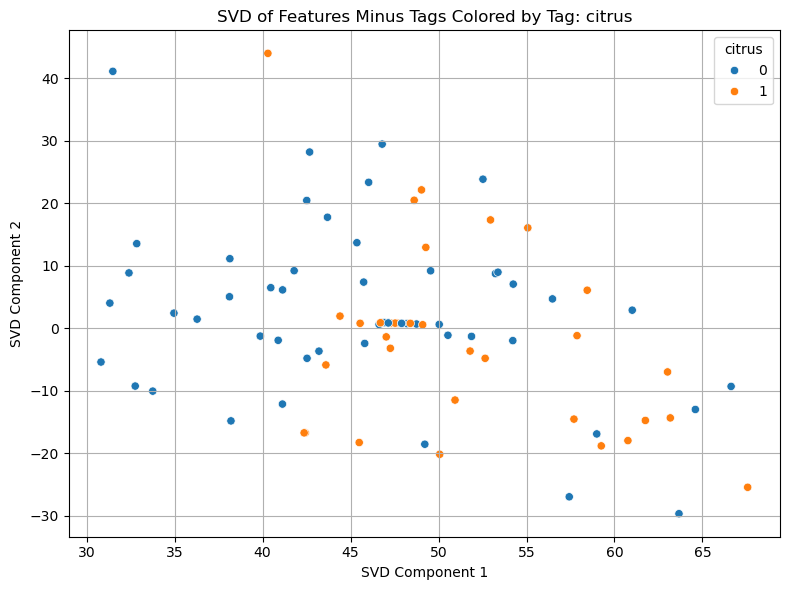

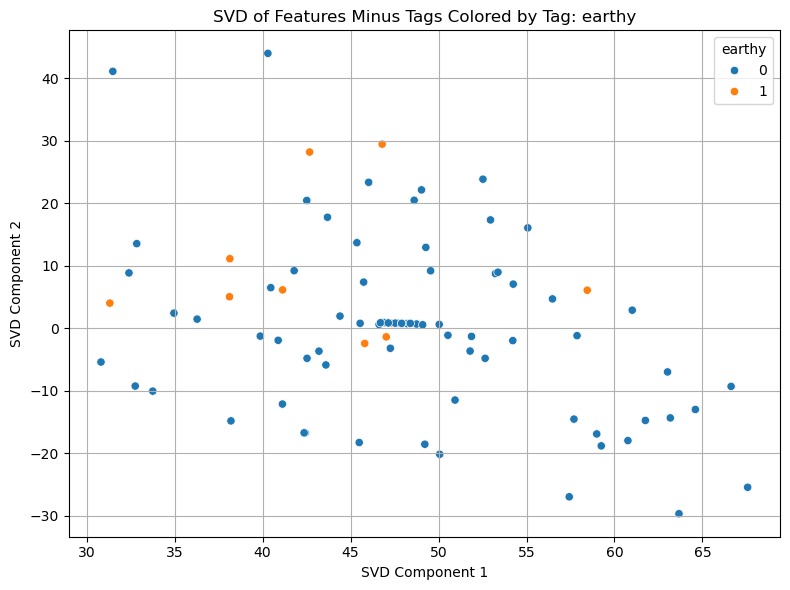

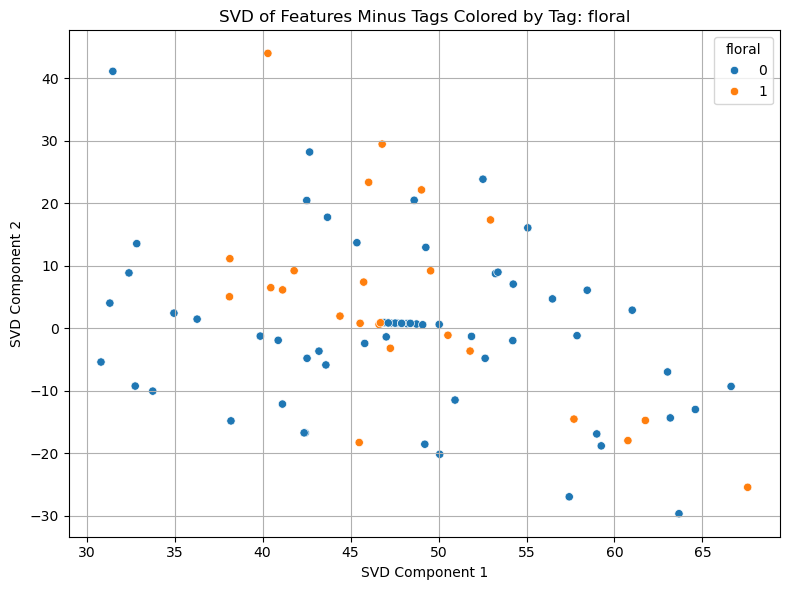

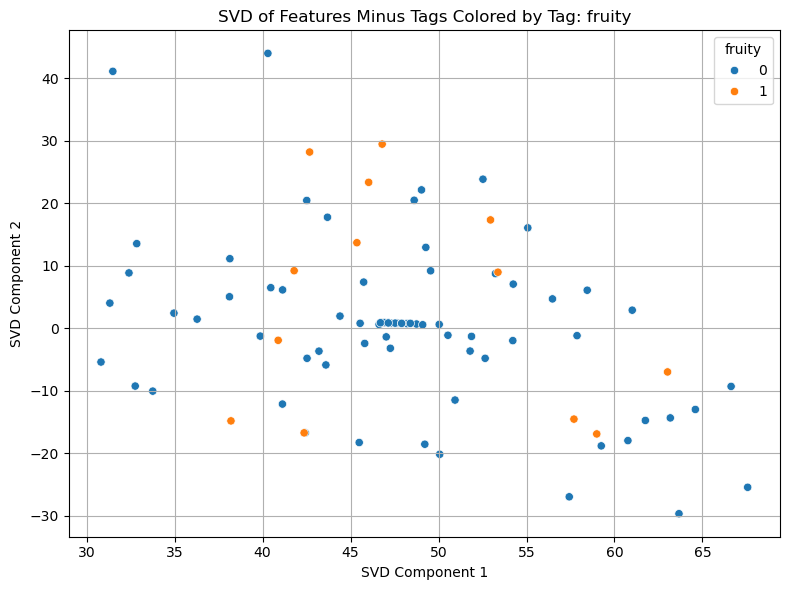

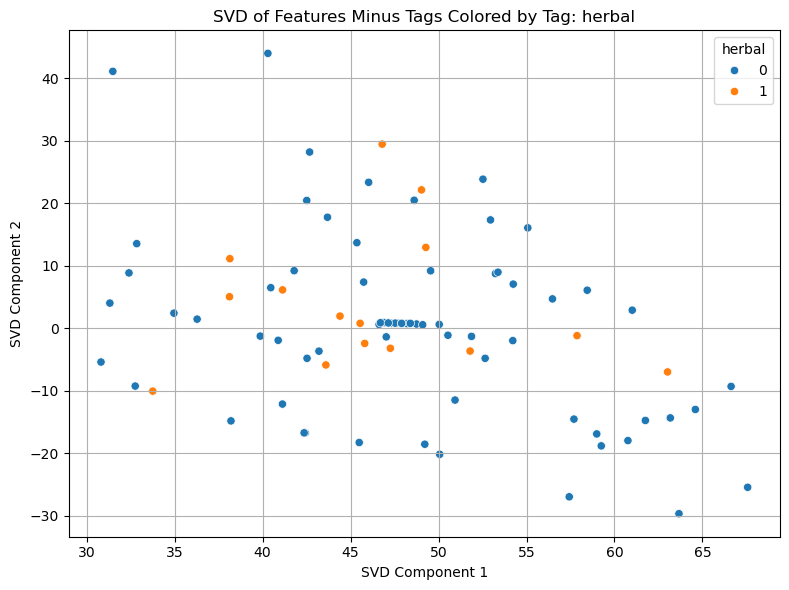

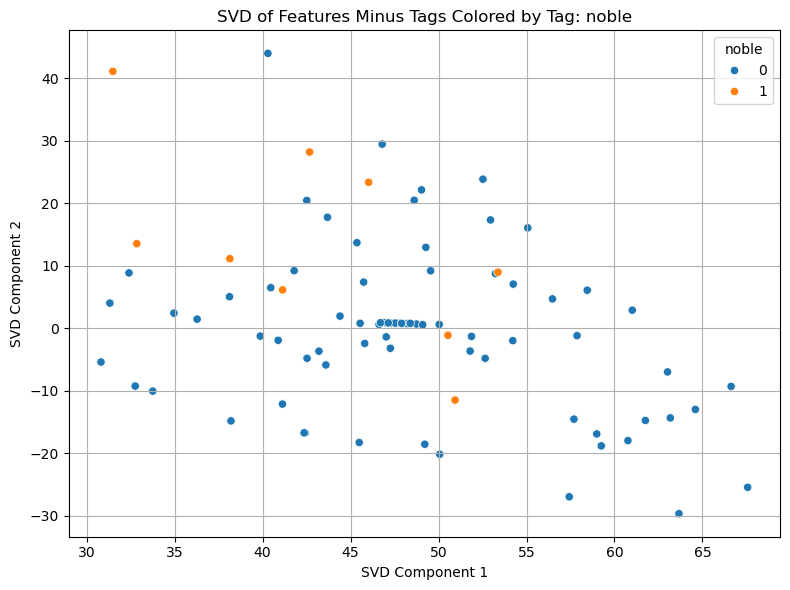

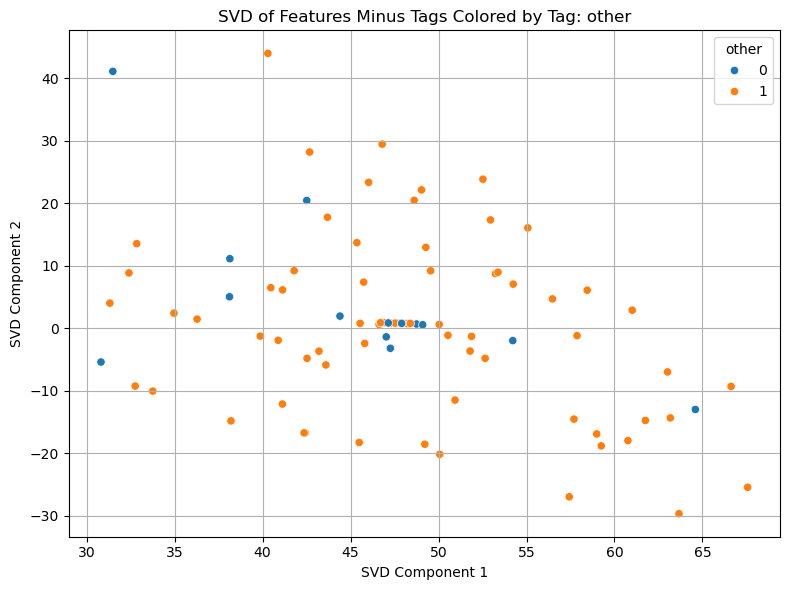

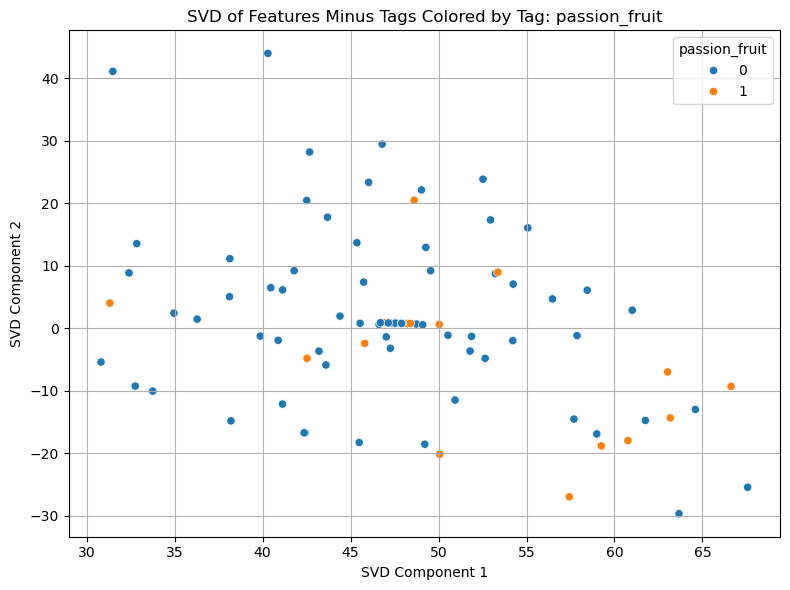

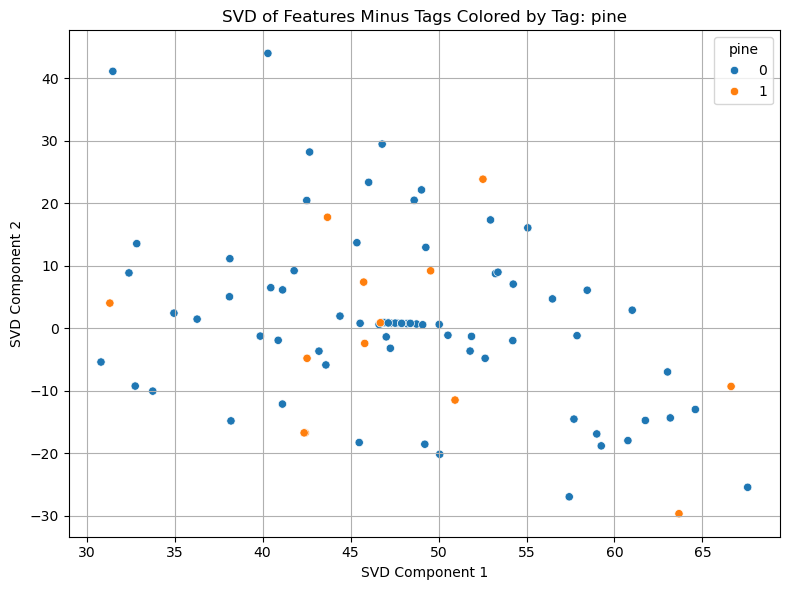

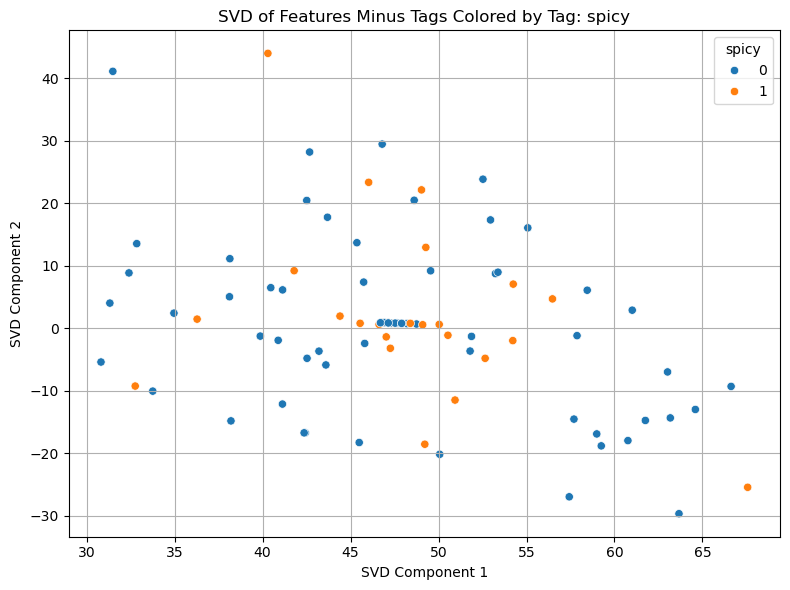

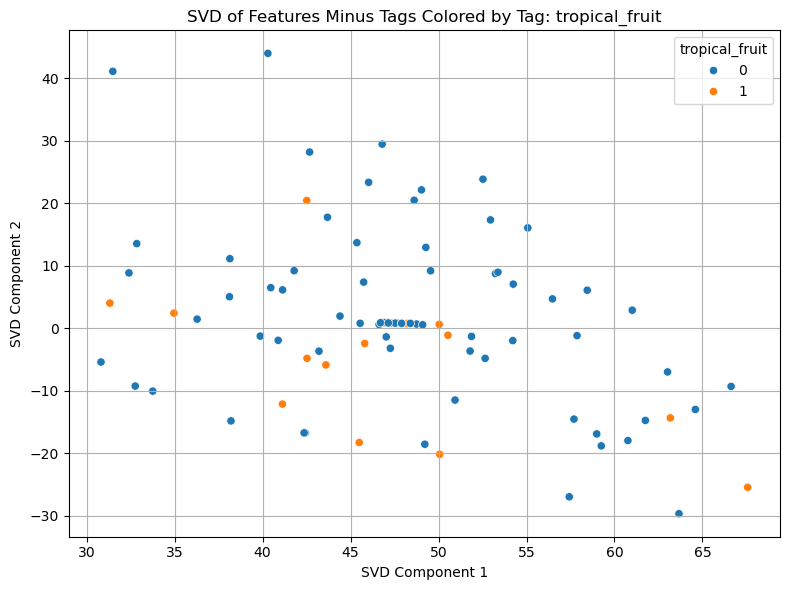

In [145]:
# Drop tag features from the full model to get a cleaner input space
features_minus_tags = df_model.drop(columns=tags_encoded.columns, errors='ignore')

# Loop over each tag
for tag in tags_encoded.columns:
    run_svd_analysis(
        features_df=features_minus_tags,
        label_series=tags_encoded[tag],
        title=f'SVD of Features Minus Tags Colored by Tag: {tag}'
    )

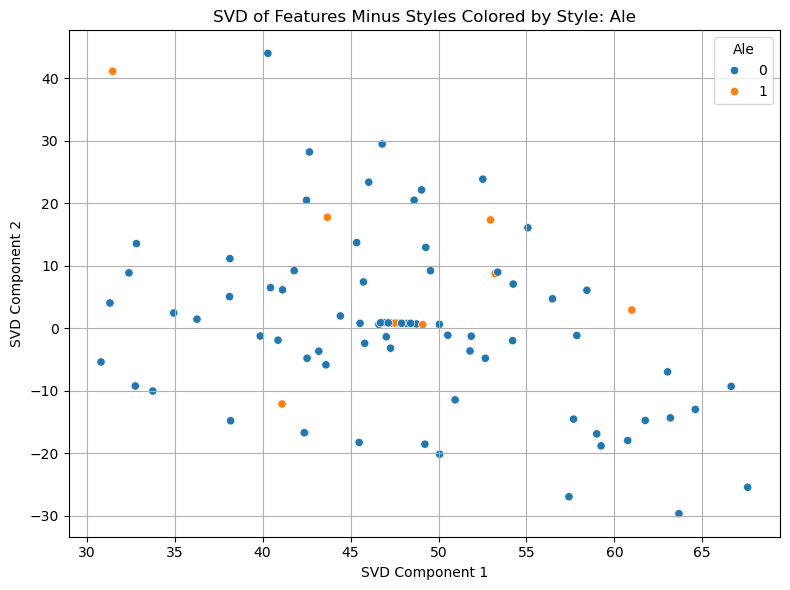

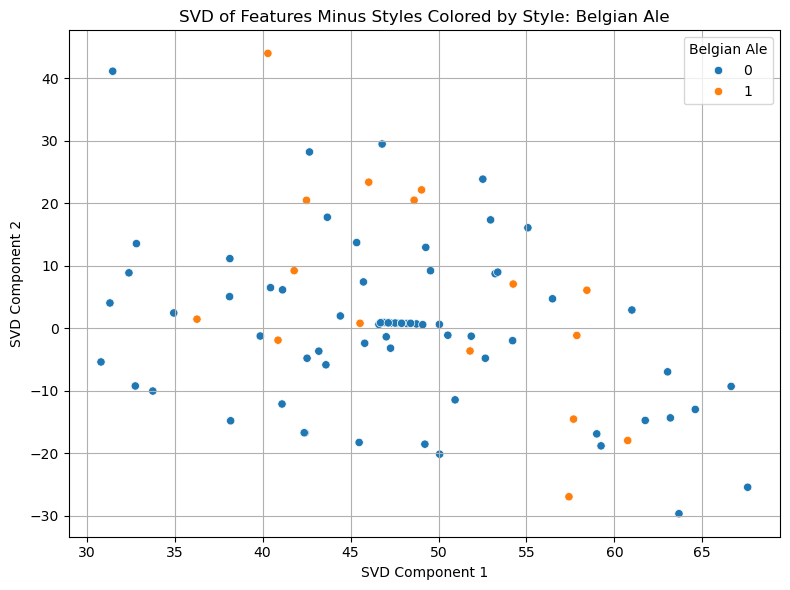

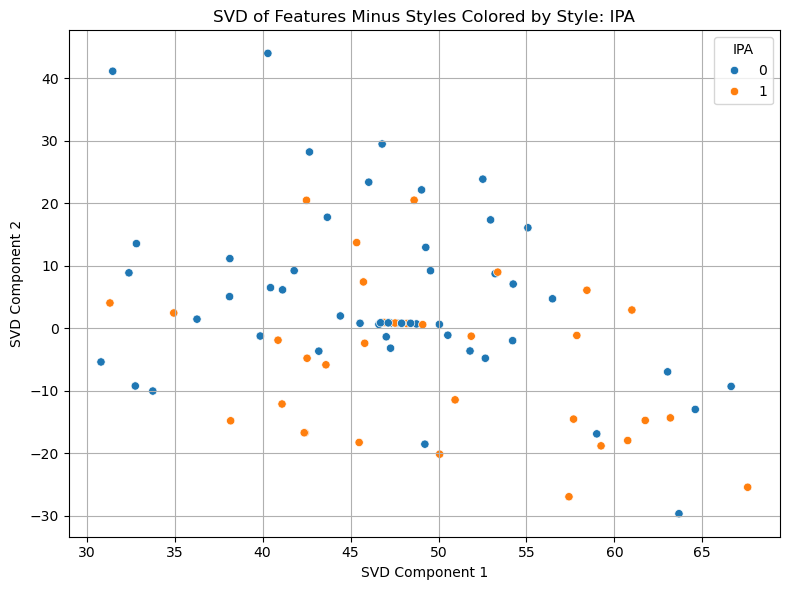

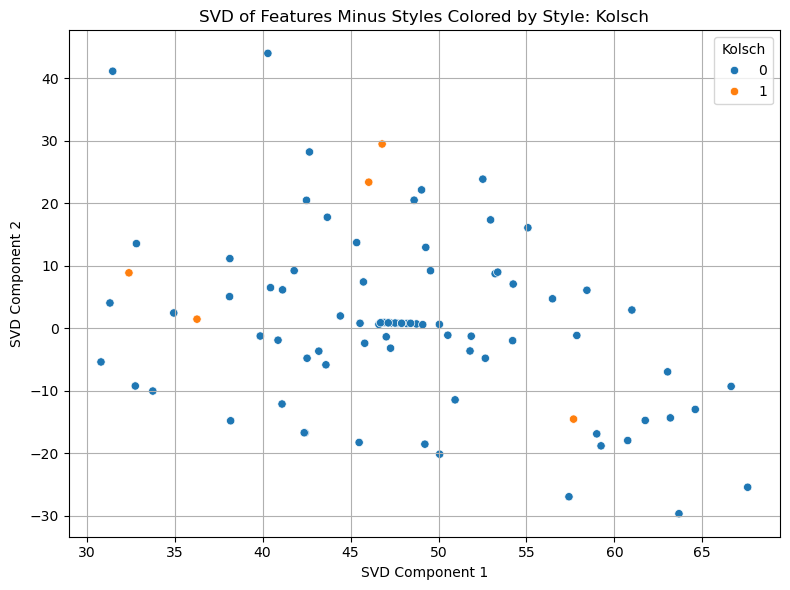

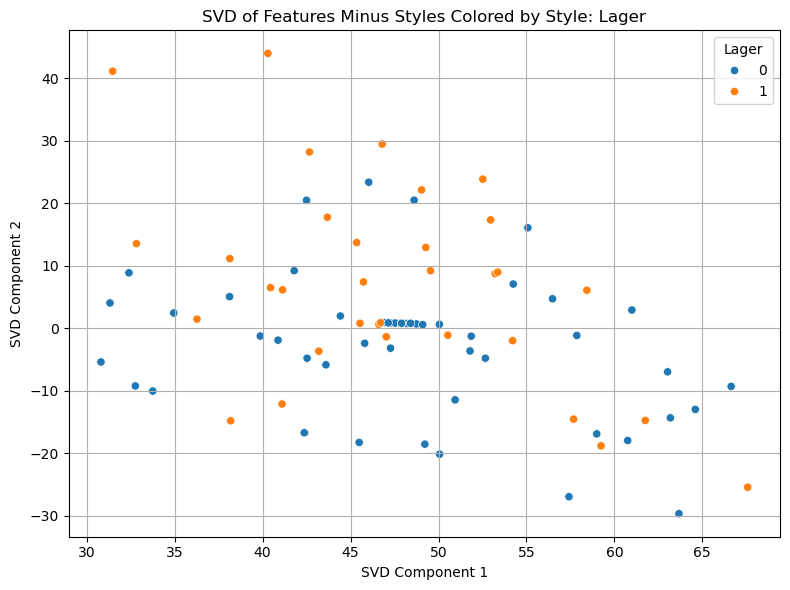

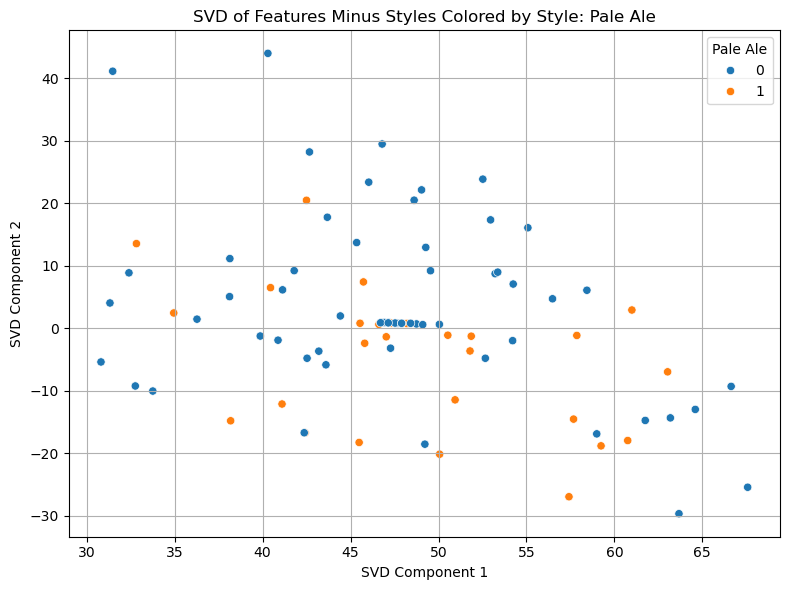

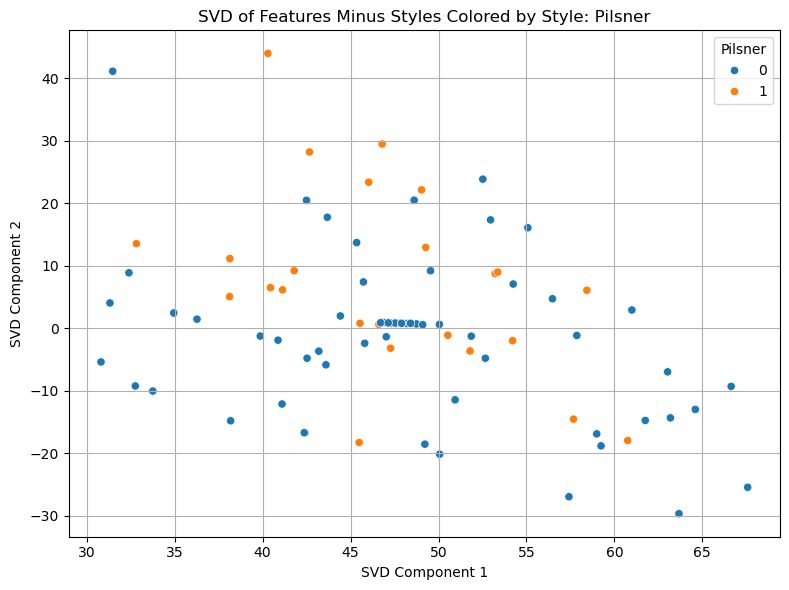

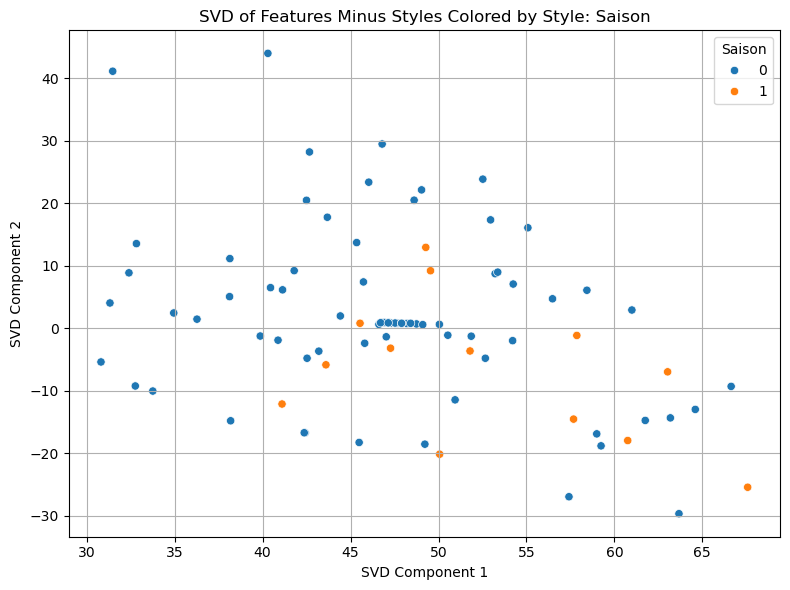

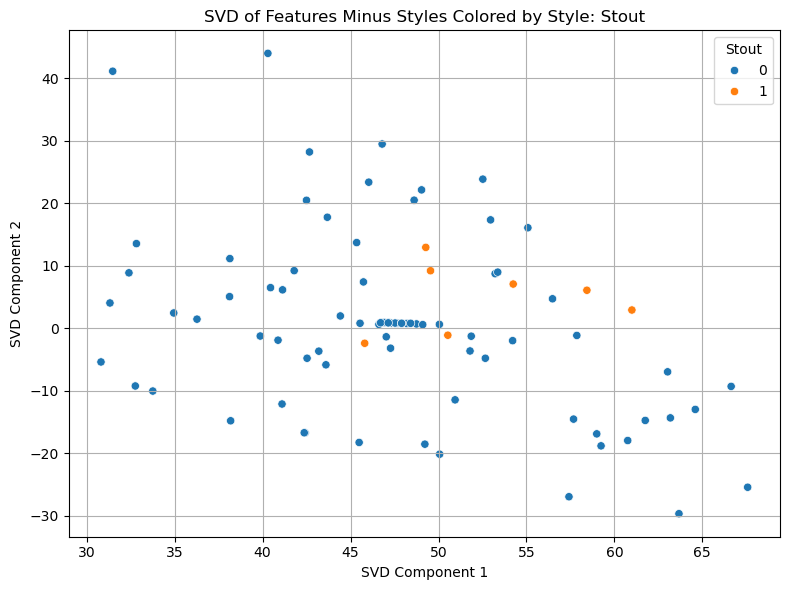

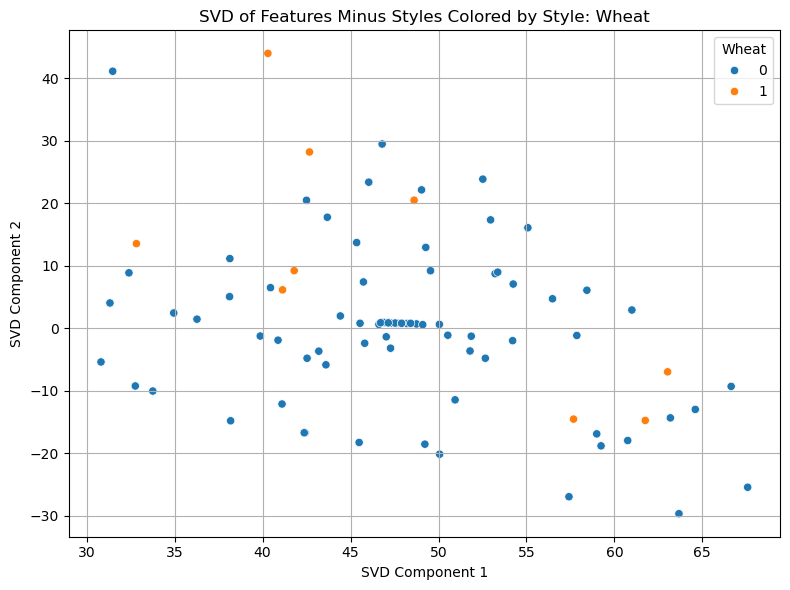

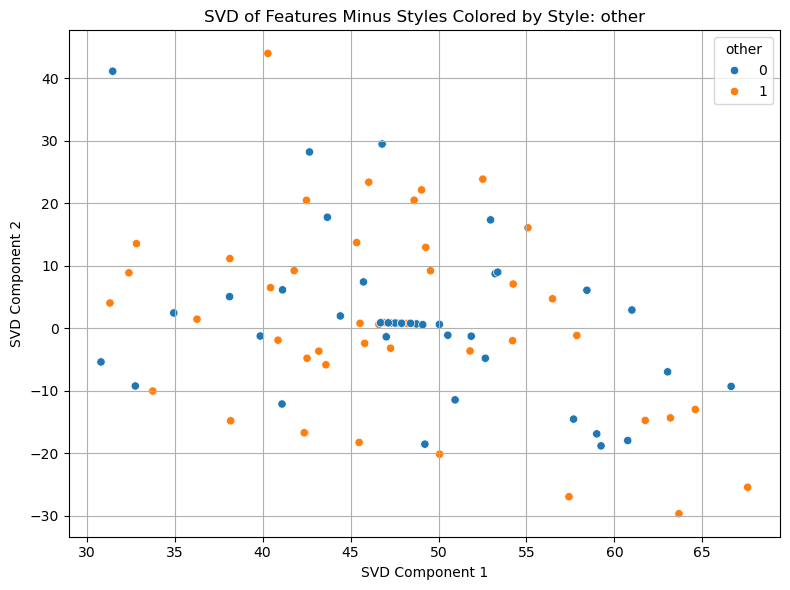

In [146]:
features_minus_styles = df_model.drop(columns=styles_encoded.columns, errors='ignore')

for style in styles_encoded.columns:
    run_svd_analysis(
        features_df=features_minus_styles,
        label_series=styles_encoded[style],
        title=f'SVD of Features Minus Styles Colored by Style: {style}'
    )

Data loaded: 100 rows × 14 columns.
      name purpose  alpha_acid_avg  beta_acid_avg  alpha_beta_ratio    hsi  \
0      NaN     NaN             NaN            NaN               NaN    NaN   
1    Astra    Dual             8.5            5.0               1.5    NaN   
2  Eclipse    Dual            17.4            7.5               1.5    NaN   
3     Ella    Dual            16.3            5.9               2.0    NaN   
4   Enigma   Aroma            16.5            5.8               2.0  0.295   

  cohumulone_%_of_alpha  total_oils_avg  myrcene  humulene  caryophyllene  \
0                   NaN             NaN      NaN       NaN            NaN   
1               27% avg             2.0      NaN       7.0            2.5   
2               35% avg             2.3     42.0       1.0            9.0   
3             36.5% avg             2.9     42.0      18.5           11.5   
4               40% avg             2.4     26.5      15.5            7.0   

   farnesene                    

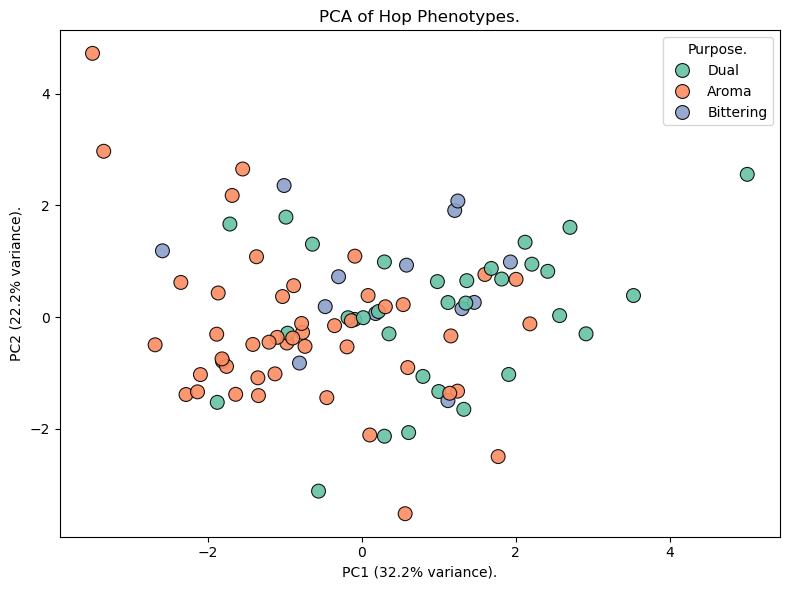

In [147]:
# Load the cleaned hop dataset from CSV into a DataFrame.
hop_df = pd.read_csv('processed_hop_data.csv')

# Confirm successful load by displaying the shape and first few rows.
print(f'Data loaded: {hop_df.shape[0]} rows × {hop_df.shape[1]} columns.')
print(hop_df.head())

# Select the features to include in the PCA analysis. These are numeric phenotypic traits.
features = ['alpha_acid_avg', 'beta_acid_avg', 'alpha_beta_ratio', 'total_oils_avg', 'myrcene', 'humulene', 'caryophyllene', 'farnesene']
df_pca = hop_df[['purpose'] + features].copy()

# Drop rows where 'purpose' is missing. This ensures all plotted points have a label for coloring.
df_pca = df_pca[df_pca['purpose'].notna()]

# Create a mean imputer to fill in any missing values in the selected numeric columns.
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the numeric feature columns.
X_imputed = imputer.fit_transform(df_pca[features])

# Standardize the features so they have zero mean and unit variance. This is essential for PCA.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Initialize the PCA object and reduce the feature set to two principal components.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert the PCA result into a new DataFrame. This will be used for plotting.
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Copy the 'purpose' column into the PCA DataFrame for coloring the plot points.
pca_df['purpose'] = df_pca['purpose'].values

# Create a scatter plot of the first two principal components, colored by hop purpose.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='purpose',
    palette='Set2',
    s=100,
    alpha=0.9,
    edgecolor='black'
)

# Add informative axis labels that include the percentage of variance explained by each PC.
plt.title('PCA of Hop Phenotypes.')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance).')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance).')
plt.legend(title='Purpose.')
plt.tight_layout()
plt.show()